In [9]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
# import GroupNormalization
from tensorflow_addons.layers import GroupNormalization

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [11]:
model_path = "/home/abharadwaj1/dev/map_sharpening/emmernet/emmernet_training/hybrid_model_map_target/outputdata/augmented_dataset_dropout_bs_2_hybrid_modelmap_lr0001_200k/saved_models/hybrid_model_map_target_final_epoch_30.hdf5"
model = load_model(model_path, custom_objects={'GroupNormalization': GroupNormalization})

In [1]:
import pickle 
#cubes_dump_dictionary_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/gas_vesicle_anisotropic/studying_cubes/dump_dictionary.pkl"
cubes_dump_dictionary_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/emmernet_cubes_sensitivity_test/emd_0193/using_fulldataset_fullnetwork/dump_dictionary.pkl"
cubes_dump_dictionary = pickle.load(open(cubes_dump_dictionary_path, "rb"))

cubes = cubes_dump_dictionary["cubes"]
cubes_predicted_mean = cubes_dump_dictionary["cubes_predicted_mean"]
cubes_dictionary = cubes_dump_dictionary["cubes_dictionary"]


In [2]:
import matplotlib.pyplot as plt

def show_cube(cube, slice_index=16):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cube[:, :, slice_index], cmap="gray")
    ax[1].imshow(cube[:, slice_index, :], cmap="gray")
    ax[2].imshow(cube[slice_index, :, :], cmap="gray")
    plt.show()



In [3]:
import numpy as np 
indices_z = []
indices_y = []
indices_x = []
for cube_index in range(len(cubes_dictionary)):
    center = cubes_dictionary[cube_index]["center"]
    indices_z.append(center[0])
    indices_y.append(center[1])
    indices_x.append(center[2])

# print unique indices in z, y and x
print(np.unique(indices_z), "indices_z")
print(np.unique(indices_y), "indices_y")
print(np.unique(indices_x), "indices_x")

[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 393] indices_z
[ 80  96 112 128 144 160 176 192 208 224 240 256 272 288 304 320 336] indices_y
[ 48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288 304 320
 336] indices_x


In [4]:
all_centers = [] 
for cube_index in range(len(cubes_dictionary)):
    center = cubes_dictionary[cube_index]["center"]
    all_centers.append(center)

In [5]:
def get_cube_index_from_zyx(z,y,x):
    for cube_index in range(len(cubes_dictionary)):
        center = cubes_dictionary[cube_index]["center"]
        if center[0] == z and center[1] == y and center[2] == x:
            return cube_index
    return None



In [6]:
def find_nearest_center_to_point(point, all_centers):
    min_distance = 100000
    min_center = None
    for center in all_centers:
        distance = np.linalg.norm(np.array(center) - np.array(point))
        if distance < min_distance:
            min_distance = distance
            min_center = center
    return min_center


In [7]:
all_centers = np.array(all_centers)
z, y, x = all_centers[:, 0], all_centers[:, 1], all_centers[:, 2]


(32, 32, 32)


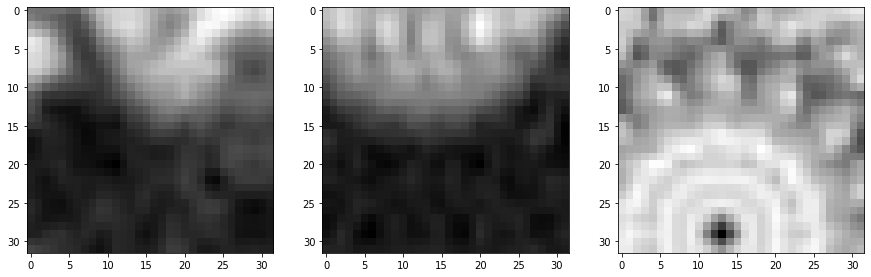

Center of the cube:  (256, 192, 208)


In [16]:
cube_index_test = get_cube_index_from_zyx(*find_nearest_center_to_point(all_centers=np.array(all_centers), point=[256, 200, 206]))
center_test = cubes_dictionary[cube_index_test]['center']
cube_test = cubes_dictionary[cube_index_test]['cube']
cube_test = np.squeeze(cube_test)
print(cube_test.shape)
show_cube(cube_test)
print("Center of the cube: ", center_test)
cube_index += 1

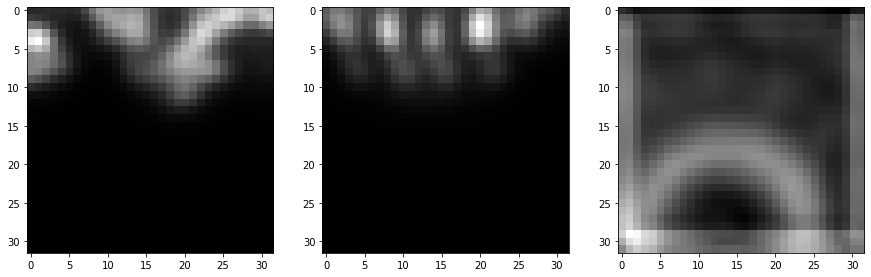

In [21]:
# predict a cube using the model 
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map, resample_map

cube_test_try = np.expand_dims(cube_test, axis=0)
cube_test_try = np.expand_dims(cube_test_try, axis=-1)
cube_predicted_try = model.predict(cube_test_try)
cube_predicted_try = np.squeeze(cube_predicted_try)
show_cube(cube_predicted_try)
output_dir_temp = "/home/abharadwaj1/papers/elife_paper/figure_information/data/emmernet_cubes_sensitivity_test/emd_0193/translation_sensitivity"
save_as_mrc(cube_predicted_try, os.path.join(output_dir_temp, "cube_predicted_at_valid_location_z_{}_y_{}_x_{}.mrc".format(*center_test)), apix=1)

In [49]:
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map, resample_map
import os 
output_dir = os.path.join(os.path.dirname(cubes_dump_dictionary_path), "test_cubes")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
input_dir = os.path.dirname(cubes_dump_dictionary_path)
emmap_path = os.path.join(input_dir, "EMD_193_unsharpened_fullmap.mrc")
emmap, apix = load_map(emmap_path)
emmap_resampled = resample_map(emmap, apix=apix, apix_new=1, order=2)
empty_map = np.zeros_like(emmap_resampled)
empty_map[center_test[0]-16:center_test[0]+16, center_test[1]-16:center_test[1]+16, center_test[2]-16:center_test[2]+16] = cube_test

test_cube_path = os.path.join(output_dir, "test_cube_z{}_y{}_x{}_i{}.mrc".format(center_test[0], center_test[1], center_test[2], cube_index_test))
resampled_empty_map = resample_map(empty_map, apix=1, apix_new=apix, order=2)
save_as_mrc(resampled_empty_map, test_cube_path, apix=apix)


In [32]:
def add_cube_to_empty_map(cube, center, reference_map, ref_apix, new_apix):
    resampled_reference_map = resample_map(reference_map, apix=ref_apix, apix_new=new_apix, order=2)
    empty_map = np.zeros_like(resampled_reference_map)
    empty_map[center[0]-16:center[0]+16, center[1]-16:center[1]+16, center[2]-16:center[2]+16] = cube
    resampled_empty_map = resample_map(empty_map, apix=new_apix, apix_new=ref_apix, order=2)
    return resampled_empty_map

In [50]:
# run a sensitivity analysis on the cube_test 
from scipy.ndimage import rotate
from tqdm import tqdm
rotation_angles = np.arange(0, 360, 5)
print(rotation_angles)
# axis of rotation is the z axis
# plane of rotation is the xy plane
rotation_axes = (1, 2)
rotated_cubes = {}
rotated_cube_save_dir = os.path.join(output_dir, "rotated_cubes")
if not os.path.exists(rotated_cube_save_dir):
    os.makedirs(rotated_cube_save_dir)
for rot_angle in tqdm(rotation_angles):
    rotated_cube = rotate(cube_test, rot_angle, axes=rotation_axes, reshape=False, order=2)
    rotated_cubes[rot_angle] = rotated_cube
    #rotated_cube_map = add_cube_to_empty_map(rotated_cube, center_test, emmap, apix, 1)
    #save_as_mrc(rotated_cube_map, os.path.join(rotated_cube_save_dir, "rotated_cube_z{}_y{}_x{}_i{}_angle{}.mrc".format(center_test[0], center_test[1], center_test[2], cube_index_test, rot_angle)), apix=apix)



[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355]


100%|██████████| 72/72 [00:00<00:00, 196.54it/s]


In [51]:
predicted_cubes = {}
for rot_angle in tqdm(rotation_angles):
    rotated_cube = rotated_cubes[rot_angle]
    rotated_cube = np.expand_dims(rotated_cube, axis=0)
    rotated_cube = np.expand_dims(rotated_cube, axis=-1)
    predicted_cube = model.predict(rotated_cube)
    predicted_cubes[rot_angle] = np.squeeze(predicted_cube)
    

100%|██████████| 72/72 [00:06<00:00, 10.74it/s]


In [52]:
predicted_cubes_dir = os.path.join(output_dir, "predicted_cubes")
if not os.path.exists(predicted_cubes_dir):
    os.makedirs(predicted_cubes_dir)
#for rot_angle in rotation_angles:
    #rotated_cube_map = add_cube_to_empty_map(predicted_cubes[rot_angle], center_test, emmap, apix, 1)
    #save_as_mrc(rotated_cube_map, os.path.join(predicted_cubes_dir, "predicted_cube_z{}_y{}_x{}_i{}_angle{}.mrc".format(center_test[0], center_test[1], center_test[2], cube_index_test, rot_angle)), apix=apix)
    
    

Text(0.5, 1.0, 'RSC vs Rotation angle')

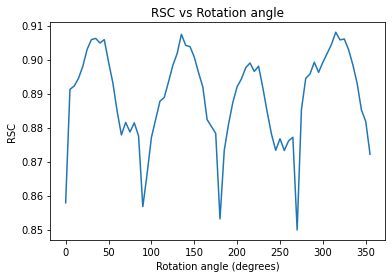

In [53]:
from locscale.include.emmer.ndimage.map_tools import compute_real_space_correlation as rsc 

rsc_angles = {} 
for rot_angle in rotation_angles:
    reference_cube = rotated_cubes[rot_angle]
    predicted_cube = predicted_cubes[rot_angle]
    rsc_angle = rsc(reference_cube, predicted_cube)
    rsc_angles[rot_angle] = rsc_angle

plt.plot(rotation_angles, rsc_angles.values())
plt.xlabel("Rotation angle (degrees)")
plt.ylabel("RSC")
plt.title("RSC vs Rotation angle")



In [54]:
import pickle 
pickle.dump(rsc_angles, open(os.path.join(output_dir, "rsc_angles_sheet.pkl"), "wb"))

In [55]:
model_path_nodropout = "/home/abharadwaj1/dev/map_sharpening/emmernet/emmernet_training/hybrid_model_map_target/outputdata/no_augmentation_model_map_cube_32_bs_2/saved_models/hybrid_model_map_target_final_epoch_15.hdf5"
model_nodropout = load_model(model_path_nodropout, custom_objects={'GroupNormalization': GroupNormalization})

In [56]:
predicted_cubes_nodropout = {}
for rot_angle in tqdm(rotation_angles):
    rotated_cube = rotated_cubes[rot_angle]
    rotated_cube = np.expand_dims(rotated_cube, axis=0)
    rotated_cube = np.expand_dims(rotated_cube, axis=-1)
    predicted_cube = model_nodropout.predict(rotated_cube)
    predicted_cubes_nodropout[rot_angle] = np.squeeze(predicted_cube)
    

100%|██████████| 72/72 [00:08<00:00,  8.59it/s]


In [ ]:
predicted_cubes_nodropout_dir = os.path.join(output_dir, "predicted_cubes_nodropout")
if not os.path.exists(predicted_cubes_nodropout_dir):
    os.makedirs(predicted_cubes_nodropout_dir)
for rot_angle in rotation_angles:
    rotated_cube_map = add_cube_to_empty_map(predicted_cubes_nodropout[rot_angle], center_test, emmap, apix, 1)
    save_as_mrc(rotated_cube_map, os.path.join(predicted_cubes_nodropout_dir, "predicted_cube_nodropout_z{}_y{}_x{}_i{}_angle{}.mrc".format(center_test[0], center_test[1], center_test[2], cube_index_test, rot_angle)), apix=apix)
    
    

In [57]:
rsc_angles_nodropout = {} 
for rot_angle in rotation_angles:
    reference_cube = rotated_cubes[rot_angle]
    predicted_cube = predicted_cubes_nodropout[rot_angle]
    rsc_angle = rsc(reference_cube, predicted_cube)
    rsc_angles_nodropout[rot_angle] = rsc_angle


Text(0.5, 1.0, 'RSC vs Rotation angle (no dropout)')

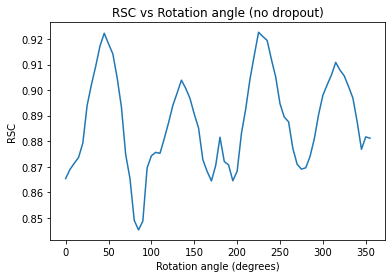

In [58]:
plt.plot(rotation_angles, rsc_angles_nodropout.values())
plt.xlabel("Rotation angle (degrees)")
plt.ylabel("RSC")
plt.title("RSC vs Rotation angle (no dropout)")


In [43]:
def polar_plot(angles, values_list, title="Polar Plot", colors=None, markers=None, labels=None):
    """
    Plot multiple data series against angles in a polar coordinate system.
    
    Parameters:
    - angles (list): List of angles (in degrees).
    - values_list (list of lists): Each inner list represents a series of values corresponding to the angles.
    - title (str): Title for the plot.
    - colors (list of str, optional): Colors for each data series. If None, a default color cycle will be used.
    - markers (list of str, optional): Marker styles for each data series. If None, 'o' will be used for all.
    - labels (list of str, optional): Labels for each data series. If None, generic labels will be generated.
    
    Returns:
    - fig (matplotlib.figure.Figure): Figure object of the plot.
    """
    
    # Convert angles to radians for the plot
    angles_rad = np.deg2rad(angles)
    
    # Set up the polar plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    
    # If colors, markers, or labels are not provided, create default ones
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if markers is None:
        markers = ['o'] * len(values_list)
    if labels is None:
        labels = [f"Series {i+1}" for i in range(len(values_list))]
    
    # Plot each data series
    for values, color, marker, label in zip(values_list, colors, markers, labels):
        ax.plot(angles_rad, values, label=label, marker=marker, color=color)
    
    # Set title and legend
    ax.set_title(title)
    ax.legend(loc="upper right")
    
    # Display the plot
    plt.show()
    
    return fig

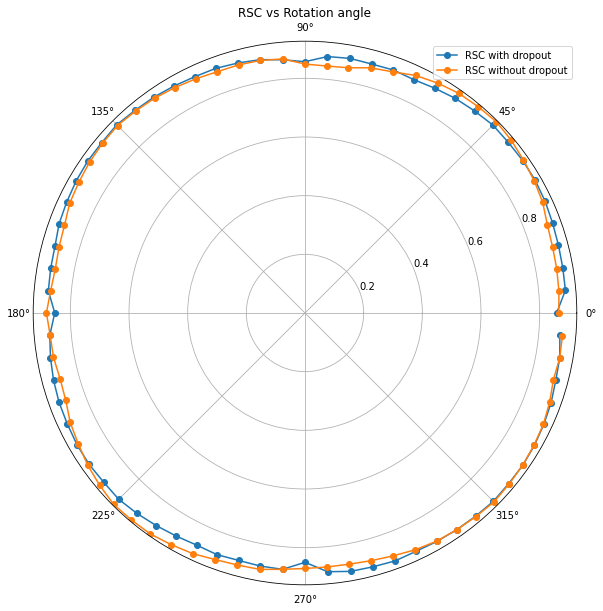

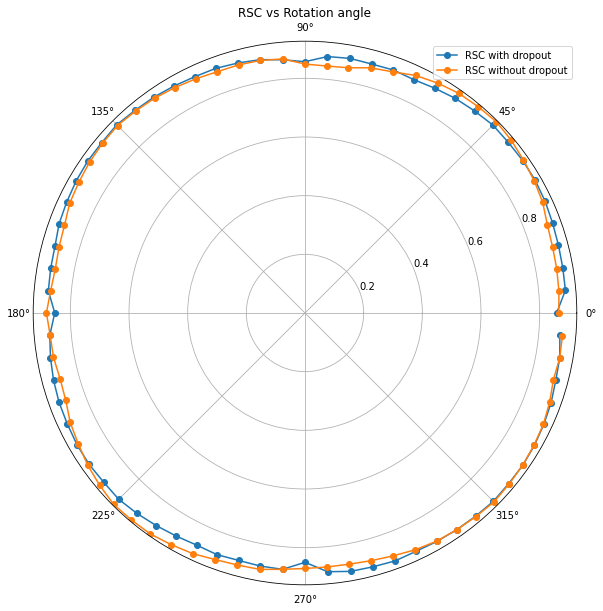

In [59]:
polar_plot(rotation_angles, [rsc_angles.values(), rsc_angles_nodropout.values()], title="RSC vs Rotation angle", labels=["RSC with dropout", "RSC without dropout"])